In [35]:
import numpy as np
import newbridge as nb
import parameters as prm
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
theta = np.zeros((prm.dof, prm.dim))
gvec = np.array([0.25, 0.25])

d_param = prm.data(theta, gvec)
d_param.theta[4, 0] = 1
d_param.theta[1, 1] = -1
d_param.theta[3, 1] = -1

euler_param = prm.euler_maruyama()
xout, tout = nb.createpaths(d_param, euler_param)

In [3]:
import pickle
with open('nem_2D.pkl','wb') as f:
    pickle.dump([xout, tout, d_param, euler_param], f)

In [4]:
print(xout.shape)

(3, 101, 2)


In [5]:
print(tout.shape)

(3, 101)


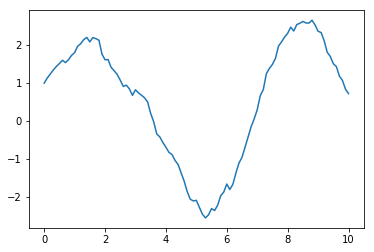

In [6]:
plt.plot(tout[0, :], xout[0, :, 0])

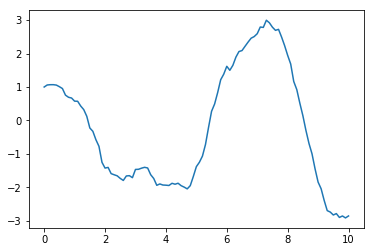

In [7]:
plt.plot(tout[0, :], xout[0, :, 1])

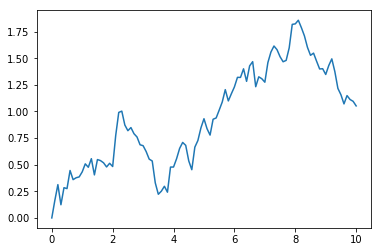

In [8]:
plt.plot(tout[1, :], xout[1, :, 0])

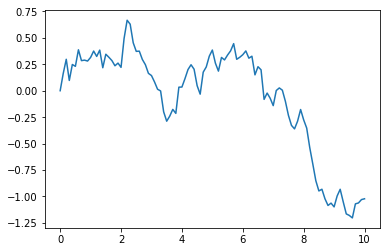

In [9]:
plt.plot(tout[1, :], xout[1, :, 1])

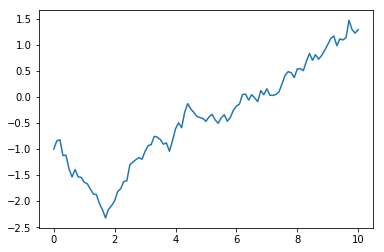

In [10]:
plt.plot(tout[2, :], xout[2, :, 0])

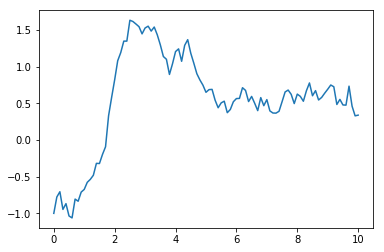

In [11]:
plt.plot(tout[2, :], xout[2, :, 1])

In [12]:
print(xout.shape)

(3, 101, 2)


In [13]:
print(tout.shape)

(3, 101)


In [14]:
x = xout[0, 0:2, :]
print(x)

[[ 1.          1.        ]
 [ 1.13297785  1.06079044]]


In [15]:
t = tout[0, 0:2]
print(t)

[ 0.   0.1]


In [16]:
# load data
import pickle
with open('nem_2D.pkl','rb') as f:
    allx, allt, d_param, euler_param = pickle.load(f)

# to check if x and t array are of correct shapes
print("Data shape:", allx.shape)
print("Theta shape:", d_param.theta.shape)

theta = np.zeros((prm.dof, prm.dim))
data_param = prm.data(theta = theta, gvec = d_param.gvec)

em_param = prm.em(dt = allt[0, 1] - allt[0, 0])
path_index = 0
step_index = 0
x = allx[path_index, step_index:(step_index + 2), :]
t = allt[path_index, step_index:(step_index + 2)]

Data shape: (3, 101, 2)
Theta shape: (16, 2)


In [17]:
def brownianbridge(d_param, em_param, xin, tin):
    h = (tin[1] - tin[0]) / em_param.numsubintervals
    tvec = tin[0] + (1 + np.arange(em_param.numsubintervals)) * h
    h12 = np.sqrt(h)

    # W ~ N(0, sqrt(h)*g)
    wincs = np.random.multivariate_normal(mean = np.zeros(prm.dim), 
        cov = h * np.diag(np.square(d_param.gvec)), 
        size = em_param.numsubintervals)
    w = np.cumsum(wincs, axis = 0).T

    bridge = xin[0, :, None] + w
    bridge -= ((tvec - tin[0])/(tin[1]-tin[0]))*(w[:, em_param.numsubintervals - 1, None] + xin[0, :, None] - xin[1, :, None])
    
    # concatenate the starting point to the bridge
    # tvec.shape is (11, ) that is (numsubintervals + 1, )
    # bridge.shape is (11, 2) that is (numsubintervals + 1, dim)
    tvec = np.concatenate((tin[[0]], tvec)).T
    bridge = np.concatenate((xin[0, :, None],bridge), axis = 1).T
    return tvec, bridge

In [18]:
print(tvec.shape)
print(bridge.shape[0])

NameError: name 'tvec' is not defined

In [ ]:
# Girsanov likelihood is computed using # TODO: insert reference to the paper
def girsanov(d_param, path):
	# path is of size (11, 2) that is (numsubintervals + 1, dim)
	# b is of size ()
    print(path.shape)
    b = drift(path, d_param)
    print(b.shape)
    print((np.diff(path)).shape)
    int1 = np.dot(b[:-1] / (d_param.gvec * d_param.gvec), np.diff(path))
    b2 = np.square(b) / (d_param.gvec * d_param.gvec)
    int2 = np.sum(0.5*(b2[1:] + b2[:-1])) * em_param.h
    r = int1 - 0.5*int2
    return r

In [ ]:
def drift(x, d_param):
	evaluated_basis = np.zeros((prm.dim, x.shape[0], prm.dof))
	out = np.zeros((x.shape[0], prm.dim))

	for i in range(prm.dim):
		evaluated_basis[i, :, :] = hermite_basis(x[:, i])
		out[:, i] = np.sum(np.dot(evaluated_basis[i, :, :], d_param.theta[:, i]))

	return out

def diffusion(d_param):
    return np.dot(d_param.gvec, np.random.standard_normal(prm.dim))

In [ ]:
_, xcur = brownianbridge(d_param, em_param, x, t)
oldlik = girsanov(d_param, xcur)

In [ ]:
x = np.array([[1., 1.], [0., 0.], [1., 1.]])
print(x.shape)
y = x[[0]]
print(y.shape)

In [ ]:
x[[0]].shape

In [ ]:
x[:,0]

In [ ]:
y = np.zeros((x.shape[0], prm.dof))
y[:, 0] = nb.H0()
y[:, 1] = nb.H1(x[:, 0])
print(y)

In [19]:
gvec * gvec

array([ 0.0625,  0.0625])

In [20]:
path = np.zeros((11, 2))
b = nb.drift(path, d_param)

In [21]:
b[:-1]

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

np.diff(path)

In [22]:
np.diff(path)

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [23]:
gvec

array([ 0.25,  0.25])

In [37]:
print("path shape in girsanov", path.shape)
b = nb.drift(path, d_param)
print("b shape in girsanov", b.shape)
u = np.dot(np.diag(np.power(d_param.gvec, -2)), b.T).T
print("u shape in girsanov", u.shape)

path shape in girsanov (11, 2)
b shape in girsanov (11, 2)
u shape in girsanov (11, 2)


In [38]:
gvec.shape

(2,)

In [39]:
np.sum(0.5*(gvec[1:] + gvec[:-1]))*0.001

0.00025000000000000001

In [55]:
theta = 0.5 * np.random.randn(prm.dof, prm.dim)

In [56]:
theta

array([[ 0.82190234, -0.31584713],
       [ 0.08524463,  0.35776639],
       [-0.07311849, -1.07851373],
       [-0.01561224,  0.74381761],
       [ 0.35137191, -0.40734043],
       [ 0.10440455, -0.79517191],
       [ 1.22432509, -0.51374657],
       [-0.05623012,  0.28408042],
       [ 0.79133246,  0.05889587],
       [-0.00389339,  0.38304457],
       [ 0.41044887,  0.26943669],
       [-0.00821383, -0.97422661],
       [-0.1960205 ,  1.22301773],
       [ 0.22647741, -0.28683795],
       [ 0.03303032, -0.38785271],
       [-0.51211065,  0.86040663]])

In [57]:
theta[np.abs(theta) < 0.1] = 0.

In [58]:
theta

array([[ 0.82190234, -0.31584713],
       [ 0.        ,  0.35776639],
       [ 0.        , -1.07851373],
       [ 0.        ,  0.74381761],
       [ 0.35137191, -0.40734043],
       [ 0.10440455, -0.79517191],
       [ 1.22432509, -0.51374657],
       [ 0.        ,  0.28408042],
       [ 0.79133246,  0.        ],
       [ 0.        ,  0.38304457],
       [ 0.41044887,  0.26943669],
       [ 0.        , -0.97422661],
       [-0.1960205 ,  1.22301773],
       [ 0.22647741, -0.28683795],
       [ 0.        , -0.38785271],
       [-0.51211065,  0.86040663]])

In [60]:
def hermite_basis(x):
    y = np.zeros((x.shape[0], prm.dof))

    index = 0
    y[:, index] = H(0, x)

    for i in range(prm.dim):
        for j in range(1, prm.polynomial_degree):
            index += 1 
            y[:, index] = H(j, x[:, i])
        # index += (prm.polynomial_degree - 1)
    if (index == dof):
        return y

    index = 7
    for i in range(1, prm.polynomial_degree):
        for j in range(1, prm.polynomial_degree):
            index += 1
            y[:, index] = y[:, i] * y[:, (prm.polynomial_degree - 1 + j)]

    if (index == dof):
        return y